<a href="https://colab.research.google.com/github/nsambel1980/causal_discovery/blob/main/AutoencoderBinary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Autoencoder for binary signal dimensionality reduction

Epoch [20/200], Loss: 0.4043
Epoch [40/200], Loss: 0.2055
Epoch [60/200], Loss: 0.1355
Epoch [80/200], Loss: 0.0966
Epoch [100/200], Loss: 0.0707
Epoch [120/200], Loss: 0.0517
Epoch [140/200], Loss: 0.0357
Epoch [160/200], Loss: 0.0279
Epoch [180/200], Loss: 0.0202
Epoch [200/200], Loss: 0.0173


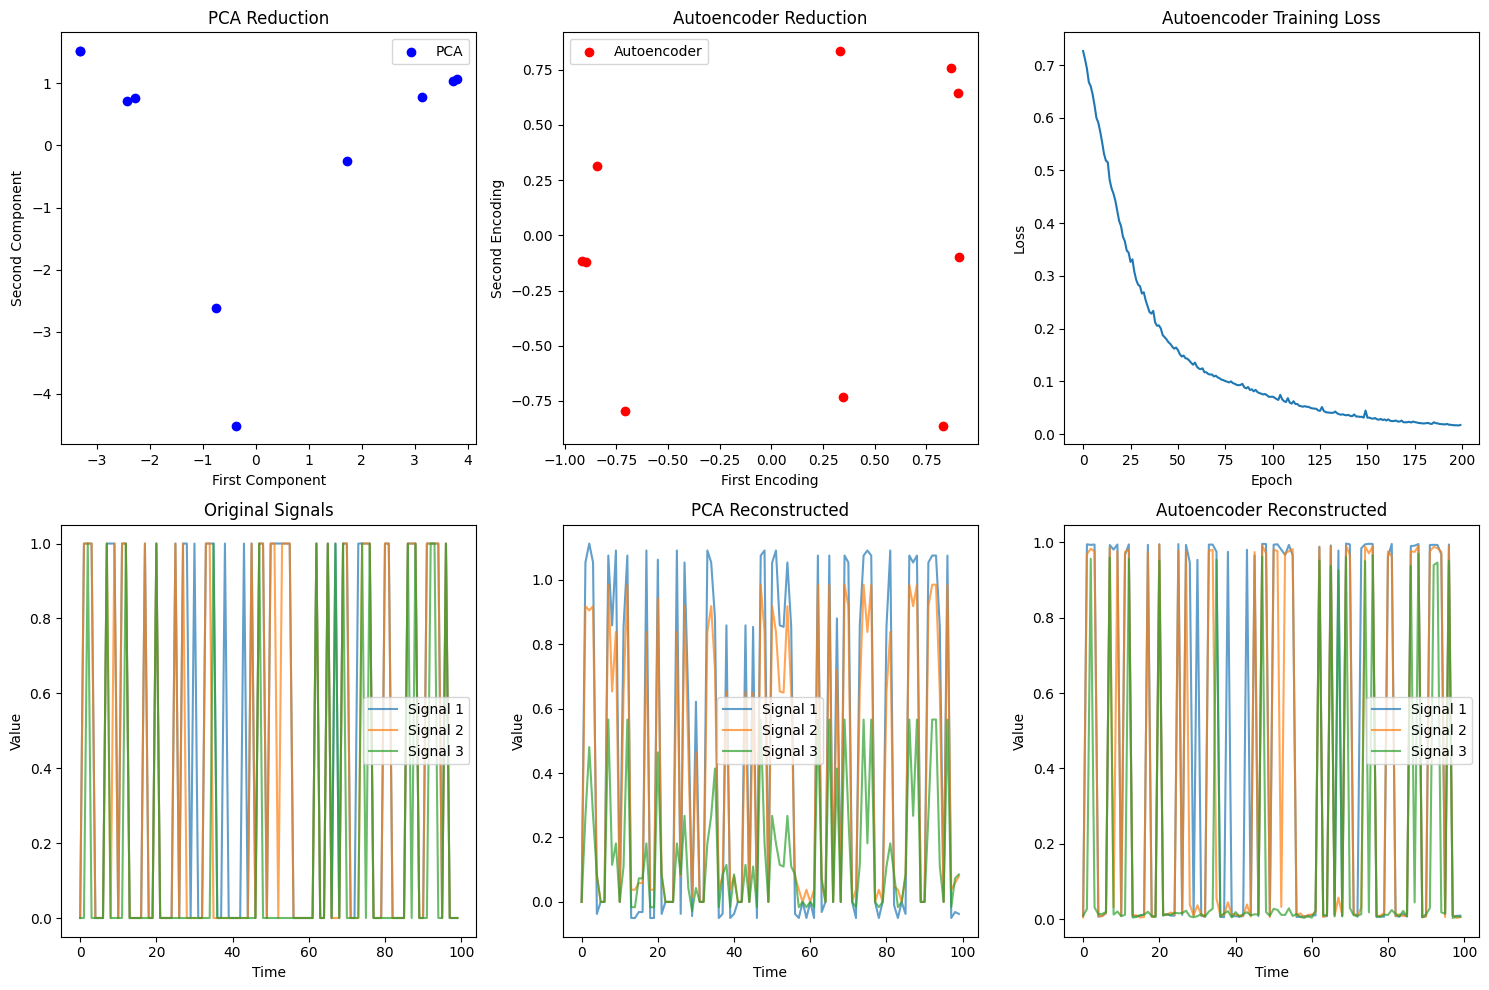


PCA explained variance ratio: [0.53199837 0.25392608]
PCA reconstruction MSE: 0.0301
Autoencoder reconstruction MSE: 0.0010

Reduced representation statistics:
PCA reduction range: -4.506922996518708 3.808189152625576
Autoencoder reduction range: -0.91836053 0.9074821


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

def generate_correlated_signals(num_signals=10, time_steps=100, seed=42):
    np.random.seed(seed)

    # Create two base patterns
    pattern1 = np.random.binomial(1, 0.5, time_steps)
    pattern2 = np.random.binomial(1, 0.5, time_steps)

    signals = []
    for i in range(num_signals):
        mix_pattern1 = np.random.random() * (0.8 if i < 5 else 0.2)
        mix_pattern2 = np.random.random() * (0.2 if i < 5 else 0.8)

        signal = mix_pattern1 * pattern1 + mix_pattern2 * pattern2 + np.random.random(time_steps) * 0.3
        signals.append((signal > 0.5).astype(int))

    return np.array(signals)

class Autoencoder(nn.Module):
    def __init__(self, input_size, encoding_dim):
        super(Autoencoder, self).__init__()

        # Improved encoder with batch normalization and dropout
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Linear(32, encoding_dim),
            nn.Tanh()  # Changed to Tanh for better gradient flow
        )

        # Improved decoder with batch normalization
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, input_size),
            nn.Sigmoid()  # Keep sigmoid for final binary output
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

def train_autoencoder(model, signals, epochs=200, batch_size=32, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    dataset = TensorDataset(torch.FloatTensor(signals))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

    losses = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in dataloader:
            x = batch[0].to(device)

            optimizer.zero_grad()
            encoded, decoded = model(x)
            loss = criterion(decoded, x)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
        scheduler.step(avg_loss)

        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

    return model, losses

def visualize_results(signals, pca_reduced, ae_reduced, pca_reconstruction, ae_reconstruction, losses):
    fig = plt.figure(figsize=(15, 10))

    # Plot 1: Dimension reduction comparison
    ax1 = fig.add_subplot(231)
    ax1.scatter(pca_reduced[:, 0], pca_reduced[:, 1], c='blue', label='PCA')
    ax1.set_title('PCA Reduction')
    ax1.set_xlabel('First Component')
    ax1.set_ylabel('Second Component')
    ax1.legend()

    ax2 = fig.add_subplot(232)
    ax2.scatter(ae_reduced[:, 0], ae_reduced[:, 1], c='red', label='Autoencoder')
    ax2.set_title('Autoencoder Reduction')
    ax2.set_xlabel('First Encoding')
    ax2.set_ylabel('Second Encoding')
    ax2.legend()

    # Plot 2: Training loss
    ax3 = fig.add_subplot(233)
    ax3.plot(losses)
    ax3.set_title('Autoencoder Training Loss')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss')

    # Plot 3: Original vs Reconstructed signals
    num_signals_to_show = 3
    time_steps = signals.shape[1]
    t = np.arange(time_steps)

    # Original signals
    ax4 = fig.add_subplot(234)
    for i in range(num_signals_to_show):
        ax4.plot(t, signals[i], label=f'Signal {i+1}', alpha=0.7)
    ax4.set_title('Original Signals')
    ax4.set_xlabel('Time')
    ax4.set_ylabel('Value')
    ax4.legend()

    # PCA reconstructed signals
    ax5 = fig.add_subplot(235)
    for i in range(num_signals_to_show):
        ax5.plot(t, pca_reconstruction[i], label=f'Signal {i+1}', alpha=0.7)
    ax5.set_title('PCA Reconstructed')
    ax5.set_xlabel('Time')
    ax5.set_ylabel('Value')
    ax5.legend()

    # Autoencoder reconstructed signals
    ax6 = fig.add_subplot(236)
    for i in range(num_signals_to_show):
        ax6.plot(t, ae_reconstruction[i], label=f'Signal {i+1}', alpha=0.7)
    ax6.set_title('Autoencoder Reconstructed')
    ax6.set_xlabel('Time')
    ax6.set_ylabel('Value')
    ax6.legend()

    plt.tight_layout()
    plt.show()

def compare_reduction_methods(signals, encoding_dim=2):
    # PCA reduction
    pca = PCA(n_components=encoding_dim)
    pca_reduced = pca.fit_transform(signals)
    pca_reconstruction = pca.inverse_transform(pca_reduced)

    # Improved Autoencoder reduction
    input_size = signals.shape[1]
    autoencoder = Autoencoder(input_size, encoding_dim)
    autoencoder, losses = train_autoencoder(autoencoder, signals, epochs=200)

    # Get encoded representations
    with torch.no_grad():
        encoded, decoded = autoencoder(torch.FloatTensor(signals))
    ae_reduced = encoded.numpy()
    ae_reconstruction = decoded.numpy()

    # Visualize results
    visualize_results(signals, pca_reduced, ae_reduced,
                     pca_reconstruction, ae_reconstruction, losses)

    # Calculate and print metrics
    print(f"\nPCA explained variance ratio: {pca.explained_variance_ratio_}")

    pca_mse = np.mean((signals - pca_reconstruction) ** 2)
    ae_mse = np.mean((signals - ae_reconstruction) ** 2)

    print(f"PCA reconstruction MSE: {pca_mse:.4f}")
    print(f"Autoencoder reconstruction MSE: {ae_mse:.4f}")

    print("\nReduced representation statistics:")
    print("PCA reduction range:", np.min(pca_reduced), np.max(pca_reduced))
    print("Autoencoder reduction range:", np.min(ae_reduced), np.max(ae_reduced))

    return pca_reduced, ae_reduced, pca, autoencoder

if __name__ == "__main__":
    signals = generate_correlated_signals()
    pca_reduced, ae_reduced, pca_model, ae_model = compare_reduction_methods(signals)